In [ ]:

import os
import cv2
import numpy as np

dataset_path = "/home/basma/Plant_Disease/dataset_tomato/"
IMG_SIZE = 128


def preprocess_image(img, filter_type="none"):

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    if filter_type == "gaussian":
        img = cv2.GaussianBlur(img, (5, 5), 0)
    elif filter_type == "median":
        img = cv2.medianBlur(img, 5)

    img = img / 255.0 
    return img

def load_dataset(dataset_path, filter_type="none"):
    data = []
    labels = []

    classes = os.listdir(dataset_path)
    classes.sort() 

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_image(img, filter_type)
            data.append(img)
            labels.append(i)

    data = np.array(data, dtype="float32")
    labels = np.array(labels)

    return data, labels, classes

# Test du preprocessing
filters = ["none", "gaussian", "median"]

for f in filters:
    print("\n==============================")
    print("Filter:", f)
    data, labels, classes = load_dataset(dataset_path, filter_type=f)
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
    print("Number of classes:", len(classes))
    print("Classes:", classes[:5])




Filter: none
Data shape: (4268, 128, 128, 3)
Labels shape: (4268,)
Number of classes: 5
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']

Filter: gaussian
Data shape: (4268, 128, 128, 3)
Labels shape: (4268,)
Number of classes: 5
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']

Filter: median
Data shape: (4268, 128, 128, 3)
Labels shape: (4268,)
Number of classes: 5
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam


EPOCHS = 10
BATCH_SIZE = 32

# ===============================
# Construction du modèle CNN
# ===============================
def build_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:

# ===============================
# Expériences avec filtres
# ===============================
results = {}

for f in filters:
    print("\n==============================")
    print("Training with filter:", f)

    # Charger dataset
    data, labels, classes = load_dataset(dataset_path, filter_type=f)
    data, labels = shuffle(data, labels, random_state=42)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(
        data, labels, test_size=0.30, random_state=42)

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42)
    # Modèle
    model = build_model(len(classes))
    model.summary()

    # Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # Évaluation
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    results[f] = test_acc
    print(f"Test accuracy with {f}: {test_acc:.4f}")


Training with filter: none


/home/basma/Plant_Disease/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.4818 - loss: 1.3321 - val_accuracy: 0.7047 - val_loss: 0.8153
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.7683 - loss: 0.6302 - val_accuracy: 0.7703 - val_loss: 0.6451
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.8581 - loss: 0.3964 - val_accuracy: 0.7672 - val_loss: 0.6523
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.9156 - loss: 0.2335 - val_accuracy: 0.7859 - val_loss: 0.6364
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.9662 - loss: 0.1140 - val_accuracy: 0.8188 - val_loss: 0.5537
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.9866 - loss: 0.0596 - val_accuracy: 0.8062 - val_loss: 0.7350
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9916 - loss: 0.0421 - val_accuracy: 0.8172 - val_loss: 0.6363
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 0.9940 - loss: 0.0265 - val_accu

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.4844 - loss: 1.2891 - val_accuracy: 0.6891 - val_loss: 0.8707
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.7365 - loss: 0.7039 - val_accuracy: 0.7094 - val_loss: 0.7753
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.8269 - loss: 0.4823 - val_accuracy: 0.7172 - val_loss: 0.8435
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.8724 - loss: 0.3458 - val_accuracy: 0.8000 - val_loss: 0.5702
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.9361 - loss: 0.1928 - val_accuracy: 0.7891 - val_loss: 0.6508
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.9471 - loss: 0.1612 - val_accuracy: 0.7875 - val_loss: 0.6935
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 0.9756 - loss: 0.0862 - val_accuracy: 0.8047 - val_loss: 0.6732
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 0.9833 - loss: 0.0556 - val_accu

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.5095 - loss: 1.2337 - val_accuracy: 0.6422 - val_loss: 0.8960
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.7650 - loss: 0.6420 - val_accuracy: 0.7469 - val_loss: 0.7045
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.8627 - loss: 0.3847 - val_accuracy: 0.7672 - val_loss: 0.6646
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.9063 - loss: 0.2838 - val_accuracy: 0.7937 - val_loss: 0.5765
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.9438 - loss: 0.1665 - val_accuracy: 0.8016 - val_loss: 0.5811
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.9659 - loss: 0.1098 - val_accuracy: 0.7609 - val_loss: 0.8446
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.9786 - loss: 0.0700 - val_accuracy: 0.8047 - val_loss: 0.7746
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 0.9873 - loss: 0.0411 - val_accu

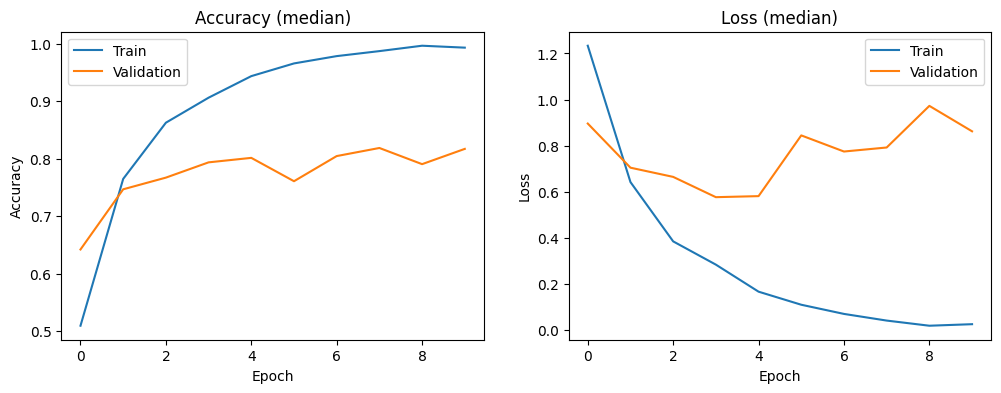

In [ ]:

# ===============================
# Courbes Accuracy / Loss
# ===============================


import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4))

    # Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title(f'Accuracy ({f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

    # Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title(f'Loss ({f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show() 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


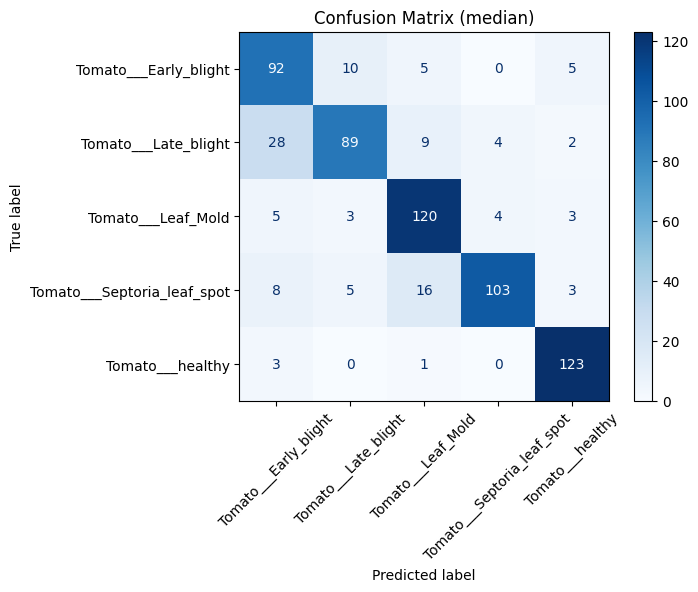

In [ ]:
# ===============================
#     Matrice de confusion
# ===============================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
   
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(f"Confusion Matrix ({f})")
plt.show()

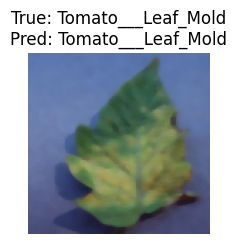

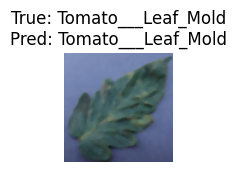

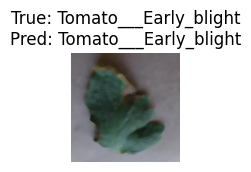

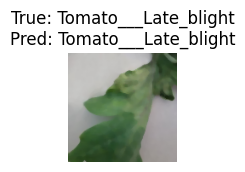

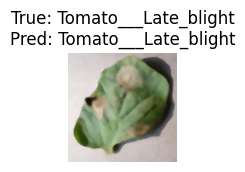

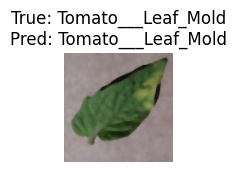

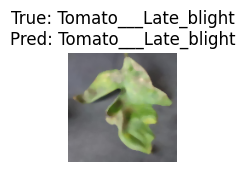

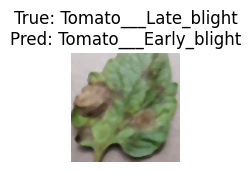

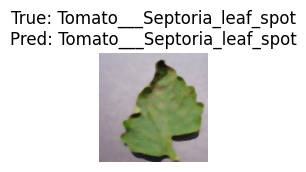

In [ ]:
# ===============================
# Affichage prédictions aléatoires
# ===============================
import random
plt.figure(figsize=(8, 8))
for i in range(9):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    true_label = classes[y_test[idx]]
    pred_label = classes[y_pred_classes[idx]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

    plt.show()

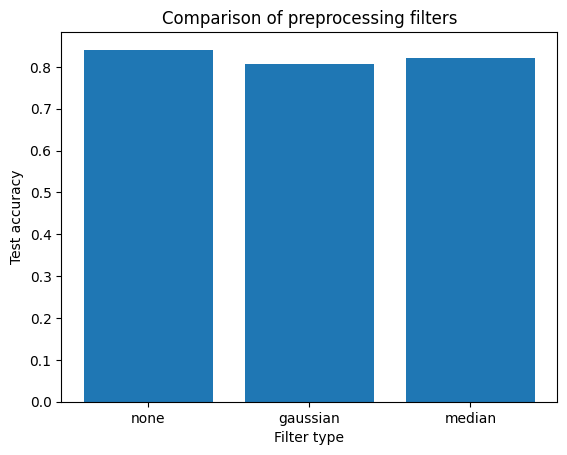


Final results:
none: 0.8409
gaussian: 0.8066
median: 0.8222


In [18]:

# ===============================
# Graphique comparaison finale
# ===============================
plt.figure()
plt.bar(results.keys(), results.values())
plt.xlabel("Filter type")
plt.ylabel("Test accuracy")
plt.title("Comparison of preprocessing filters")
plt.show()

print("\nFinal results:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

In [26]:
from tensorflow.keras.preprocessing import image

def predict_new_image(model, img_path, classes, filter_type="none"):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    img = preprocess_image(img, filter_type)

    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class = classes[np.argmax(prediction)]

    return predicted_class
